Imports

In [25]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrices
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore", category=ConvergenceWarning)

Load data

In [26]:
df = pd.read_csv("Credit.csv")
df = df.drop('Unnamed: 0', axis=1)
df['inc_gt_50'] = (df['Income'] > 50).astype(int)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
 11  inc_gt_50  400 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB
None


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,inc_gt_50
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,1
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,1
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,1


Logistic Regression

In [27]:
def logisticRegression(df, formula, seed=1):
    np.random.seed(seed)
    mask = np.random.rand(len(df)) < 0.8
    train_set = df[mask]
    valid_set = df[~mask]
    
    train_y, train_x = dmatrices(formula, data=train_set, return_type="dataframe")
    valid_y, valid_x = dmatrices(formula, data=valid_set, return_type="dataframe")
    
    model = LogisticRegression(fit_intercept = False, C = 1e9, max_iter=1000)
    train_y = np.array(train_y).reshape(len(train_y,))
    model.fit(train_x, train_y)
    
    train_acc = accuracy_score(train_y, model.predict(train_x))
    val_acc = accuracy_score(valid_y, model.predict(valid_x))
    val_maj_proportion = max(valid_set[formula.split()[0]].value_counts(normalize=True))

    return train_acc, val_acc, val_maj_proportion

Predict income greater than 50

In [28]:
df_numeric = pd.get_dummies(df, columns=["Gender", "Student", "Married", "Ethnicity"], drop_first=True)
correlation_matrix = df_numeric.corr()
print("inc_gt_50:")
print(correlation_matrix["inc_gt_50"].drop("inc_gt_50").sort_values(ascending=False))

inc_gt_50:
Income                 0.797502
Limit                  0.634231
Rating                 0.628991
Balance                0.349252
Age                    0.166677
Married_Yes            0.022746
Ethnicity_Caucasian    0.014163
Gender_Female          0.008979
Student_Yes           -0.007207
Education             -0.023899
Cards                 -0.026562
Ethnicity_Asian       -0.032493
Name: inc_gt_50, dtype: float64


In [29]:
formulas = [
    "inc_gt_50 ~ Limit",
    "inc_gt_50 ~ Rating",
    "inc_gt_50 ~ Cards",
    "inc_gt_50 ~ Age",
    "inc_gt_50 ~ Education",
    "inc_gt_50 ~ Gender",
    "inc_gt_50 ~ Student",
    "inc_gt_50 ~ Married",
    "inc_gt_50 ~ Ethnicity",
    "inc_gt_50 ~ Balance",
]
better_formulas = [
    "inc_gt_50 ~ Limit + Rating",
    "inc_gt_50 ~ Limit + Balance",
    "inc_gt_50 ~ Rating + Balance",
    "inc_gt_50 ~ Limit + Rating + Balance",
    "inc_gt_50 ~ Limit + Rating + Balance + Age",
]

seed = np.random.randint(2**32)
train_acc, val_acc, val_maj_proportion = logisticRegression(df, "inc_gt_50 ~ Limit", seed)
print(f"\033[91mMajority class proportion of validation set: {val_maj_proportion:.4f}\033[0m")
for f in formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, val_maj_proportion = logisticRegression(df, f, seed)
    print(f"\tValidation accuracy: {val_acc:.4f}")
print("--------------------------------------")
for f in better_formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, val_maj_proportion = logisticRegression(df, f, seed)
    print(f"\tTraining accuracy: {train_acc:.4f}")
    print(f"\tValidation accuracy: {val_acc:.4f}")

Majority class proportion of validation set: 0.6933
inc_gt_50 ~ Limit:
	Validation accuracy: 0.8133
inc_gt_50 ~ Rating:
	Validation accuracy: 0.8267
inc_gt_50 ~ Cards:
	Validation accuracy: 0.6933
inc_gt_50 ~ Age:
	Validation accuracy: 0.7067
inc_gt_50 ~ Education:
	Validation accuracy: 0.6933
inc_gt_50 ~ Gender:
	Validation accuracy: 0.6933
inc_gt_50 ~ Student:
	Validation accuracy: 0.6933
inc_gt_50 ~ Married:
	Validation accuracy: 0.6933
inc_gt_50 ~ Ethnicity:
	Validation accuracy: 0.6933
inc_gt_50 ~ Balance:
	Validation accuracy: 0.7467
--------------------------------------
inc_gt_50 ~ Limit + Rating:
	Training accuracy: 0.8338
	Validation accuracy: 0.8267
inc_gt_50 ~ Limit + Balance:
	Training accuracy: 0.9446
	Validation accuracy: 0.9733
inc_gt_50 ~ Rating + Balance:
	Training accuracy: 0.9323
	Validation accuracy: 0.9733
inc_gt_50 ~ Limit + Rating + Balance:
	Training accuracy: 0.9385
	Validation accuracy: 0.9733
inc_gt_50 ~ Limit + Rating + Balance + Age:
	Training accuracy: 0.

Predict number of cards

In [30]:
df_numeric = pd.get_dummies(df, columns=["Gender", "Student", "Married", "Ethnicity"], drop_first=True)
correlation_matrix = df_numeric.corr()
print("Cards:")
print(correlation_matrix["Cards"].drop("Cards").sort_values(ascending=False))

Cards:
Balance                0.086456
Rating                 0.053239
Age                    0.042948
Limit                  0.010231
Ethnicity_Asian        0.005591
Ethnicity_Caucasian   -0.005631
Married_Yes           -0.009695
Income                -0.018273
Gender_Female         -0.022658
Student_Yes           -0.026164
inc_gt_50             -0.026562
Education             -0.051084
Name: Cards, dtype: float64


In [31]:
formulas = [
    "Cards ~ Income",
    "Cards ~ Limit",
    "Cards ~ Rating",
    "Cards ~ Age",
    "Cards ~ Education",
    "Cards ~ Gender",
    "Cards ~ Student",
    "Cards ~ Married",
    "Cards ~ Ethnicity",
    "Cards ~ Balance",
]
better_formulas = [
    "Cards ~ Balance + Rating",
    "Cards ~ Balance + Rating + Education",
    "Cards ~ Balance + Rating + Age",
    "Cards ~ Balance + Rating + Education + Age",
    "Cards ~ Balance + Rating + Education + Age + Limit",
    "Cards ~ Balance + Rating + Education + Age + Limit + inc_gt_50",
    "Cards ~ Balance + Rating + Education + Age + Limit + inc_gt_50 + Student",
    "Cards ~ Balance + Rating + Education + Age + Limit + inc_gt_50 + Student + Gender",
]

seed = np.random.randint(2**32)
train_acc, val_acc, val_maj_proportion = logisticRegression(df, "Cards ~ Limit", seed)
print(f"\033[91mMajority class proportion of validation set: {val_maj_proportion:.4f}\033[0m")
for f in formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, val_maj_proportion = logisticRegression(df, f, seed)
    print(f"\tValidation accuracy: {val_acc:.4f}")
print("--------------------------------------")
for f in better_formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, val_maj_proportion = logisticRegression(df, f, seed)
    print(f"\tTraining accuracy: {train_acc:.4f}")
    print(f"\tValidation accuracy: {val_acc:.4f}")

Majority class proportion of validation set: 0.3625
Cards ~ Income:


	Validation accuracy: 0.1875
Cards ~ Limit:
	Validation accuracy: 0.1875
Cards ~ Rating:
	Validation accuracy: 0.1875
Cards ~ Age:
	Validation accuracy: 0.1750
Cards ~ Education:
	Validation accuracy: 0.1875
Cards ~ Gender:
	Validation accuracy: 0.1875
Cards ~ Student:
	Validation accuracy: 0.1875
Cards ~ Married:
	Validation accuracy: 0.1875
Cards ~ Ethnicity:
	Validation accuracy: 0.2000
Cards ~ Balance:
	Validation accuracy: 0.1875
--------------------------------------
Cards ~ Balance + Rating:
	Training accuracy: 0.2969
	Validation accuracy: 0.2500
Cards ~ Balance + Rating + Education:
	Training accuracy: 0.3094
	Validation accuracy: 0.1750
Cards ~ Balance + Rating + Age:
	Training accuracy: 0.2969
	Validation accuracy: 0.1875
Cards ~ Balance + Rating + Education + Age:
	Training accuracy: 0.3125
	Validation accuracy: 0.2000
Cards ~ Balance + Rating + Education + Age + Limit:
	Training accuracy: 0.4062
	Validation accuracy: 0.3750
Cards ~ Balance + Rating + Education + Age + Limit

Analyze number of cards

count    400.000000
mean       2.957500
std        1.371275
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: Cards, dtype: float64


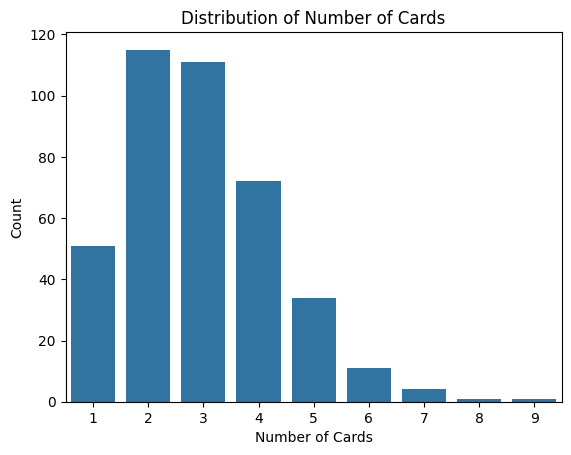

In [32]:
print(df["Cards"].describe())

sns.countplot(x=df["Cards"])
plt.title("Distribution of Number of Cards")
plt.xlabel("Number of Cards")
plt.ylabel("Count")
plt.show()